In [1]:
import CodaPCA
import CodaCl 
import PCACl
import numpy as np
from runpca import read_csv
import os
import sklearn
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
#change module for newer sklearn versions
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection  import KFold
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import dill

In [2]:
def enhanced_cross_val(features, targets, folds):
    assert len(features) == len(targets), "Mismatch in length of features and targets"
    kfold_scores = []
    for train, test in folds:
        Y_train = targets[train]
        X_train = features[train]
               
        Y_test = targets[test]
        X_test = features[test]
                
        model = LogisticRegression(multi_class='auto', solver='lbfgs')
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        kfold_scores.append(sklearn.metrics.accuracy_score(Y_test,y_pred))
                
    return kfold_scores

#can automate this if we had assume a certain structure for the indices of features and targets, or an array per dataset 




In [3]:
def coda_val(features, targets, n_components, folds, nn_shape,  lr,lam, epochs):
    kfold_scores = []
    for train, test in folds:        
        Y_train = targets[train]
        X_train = features[train]
        
       
        Y_test = targets[test]
        X_test = features[test]
        
        
        model = CodaCl.CoDA_Cl(130, n_components, 2, nn_shape[0], nn_shape[1])


        val_arr, train_arr = model.fit(X_train, Y_train, lam, lr, train_size = int(len(X_train)*(3/4)), epochs=epochs)
        
        print ("Plot!")
        
        plt.plot(val_arr, c="red")
        plt.plot(train_arr, c="blue")
        
        plt.ylim(bottom=min(train_arr))

        plt.show()
        
        pred = model.predict(torch.FloatTensor(X_test))
        
        pred = pred.exp().detach()     
        _, index = torch.max(pred,1)  
        pred = pred.numpy()
        index = index.numpy()
        
        kfold_scores.append(sklearn.metrics.accuracy_score(Y_test,index))
                
    return kfold_scores


In [4]:
def PCA_Classification(data, co_feature_indices, target_index, 
                   other_feature_indices = [], alg=CodaPCA.Alg.CODAPCA, verbose=True):
       #can loop through/optimise this in another way?
    
    features = np.array(data[:,co_feature_indices],dtype=np.float32)
    
    features_ = features
    
    targets = data[:,target_index]
    
    le = LabelEncoder()
    le.fit(targets)
    targets = le.transform(targets)
    #set up as int list, and subtract to get index so NLL loss works
#     targets = list(map(int,data[:,0]))
#     targets = [target - 1 for target in targets]

    
    #normalise the compositional features. TODO anything extra to deal with non compositional features?
    features = np.array([feat/sum(feat) for feat in features])

    #can be empty
    extra_features = data[:,other_feature_indices]
    
    #TODO double check this
    features = np.hstack([features, extra_features])
    

    n_components=20
#     print(features)

    
    pca_coda = CodaPCA.NonParametricCodaPCA(n_components)
    Y_coda = pca_coda.fit_transform(np.array(features, dtype=np.float32))

    pca_clr = CodaPCA.CLRPCA(n_components)
    Y_clr = pca_clr.fit_transform(np.array(features, dtype=np.float32))
    
    
    
    sc = StandardScaler()
    features_ = sc.fit_transform(np.array(features, dtype=np.float32))

    pca_reg = decomposition.PCA(n_components)

    pca_reg.fit(features_)
    Y_pca = pca_reg.transform(features_)
  

    splits = 4
    #split data 
    kf = KFold(splits)
        
    folds = [i for i in kf.split(features)] 

    coda_score = enhanced_cross_val(Y_coda, np.array(targets), folds)
    clr_score = enhanced_cross_val(Y_clr, np.array(targets), folds) 
    naive_score = enhanced_cross_val(Y_pca, np.array(targets), folds)

#     import itertools
#     nn_vals = [[[5,], [2,]]]#, [[10,],[5,]], [[10,5], [3,5]], [[50,], [20,]], [[50,20], [10,20]]]
#     lr_vals = [1e-3]#, 1e-3, 5e-4,1e-4 ]
#     lam_vals = [1e-12]#1e-12,5e-12,1e-11,5e-11,1e-10,5e-10,1e-5,1e-4,0.001,0.1,1,10,100]
#     epoch_vals = [5000]

#     param_list = list(itertools.product(*[nn_vals, lr_vals, lam_vals, epoch_vals]))
# #     param_file = open("paramresultswineclass.txt","w") 
# #     param_file.write("Results from hyperparameter grid search:\n\n") 

#     param_dict = {}
        
#     for params in param_list:
#         nn_shape = params[0]
#         lr = params[1]
#         lam = params[2]
#         n_epochs = params[3]

#         score = coda_val(features, np.array(targets), 2, folds, nn_shape, lr, lam, n_epochs )

#         param_dict[tuple([sum(nn_shape[0]) + sum(nn_shape[1]), lr, lam, n_epochs])] = np.mean(score)
#         param_file.write("nn {}, lr {}, lam {}, epochs {}, num_samples {}, num_features {} \nScore: {} \nMean_score: {} \n\n".format(nn_shape, lr, lam, n_epochs, len(features), len(co_feature_indices), score, np.mean(score)))

#         param_file.close()

    #codacl_score = coda_val(features, np.array(targets), n_components, folds)

    nn_shape = [[50], [50]]
    lr = 1e-3
    lam = 1e-10
    n_epochs = 200

    codacl_score = coda_val(np.array(features,dtype=np.float32), np.array(targets), 20, folds, nn_shape, lr, lam, n_epochs )
    
    if verbose:
        print("CoDA-PCA:")
        print(coda_score)
        print("CLR-PCA:")
        print(clr_score)
        print ("Naive Classification:")
        print (naive_score)
        print ("Coda Cl:")
        print (codacl_score)

    return coda_score,clr_score,naive_score,codacl_score


In [5]:
import pandas as pd
import numpy as np
diet_data = pd.read_hdf('dietswap.h5','dietswap')

data = diet_data.to_numpy()
np.random.shuffle(data)

Plot!


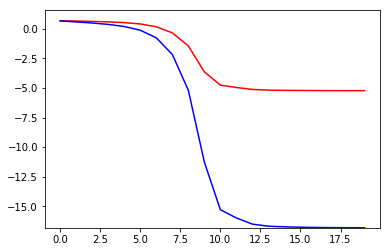

Plot!


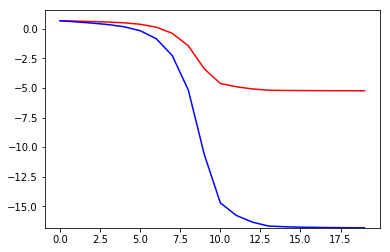

Plot!


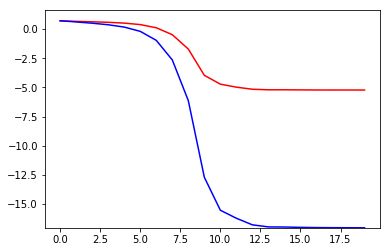

Plot!


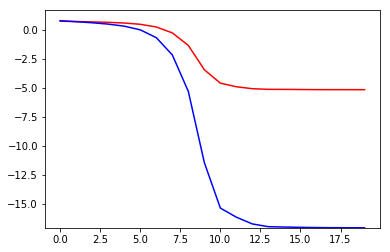

CoDA-PCA:
[0.9464285714285714, 0.9285714285714286, 0.9454545454545454, 0.9818181818181818]
CLR-PCA:
[0.9821428571428571, 0.9821428571428571, 0.9636363636363636, 1.0]
Naive Classification:
[0.8928571428571429, 0.9285714285714286, 0.9454545454545454, 0.9454545454545454]
Coda Cl:
[0.5178571428571429, 0.5714285714285714, 0.5454545454545454, 0.5818181818181818]


([0.9464285714285714,
  0.9285714285714286,
  0.9454545454545454,
  0.9818181818181818],
 [0.9821428571428571, 0.9821428571428571, 0.9636363636363636, 1.0],
 [0.8928571428571429,
  0.9285714285714286,
  0.9454545454545454,
  0.9454545454545454],
 [0.5178571428571429,
  0.5714285714285714,
  0.5454545454545454,
  0.5818181818181818])

In [6]:
%matplotlib inline
PCA_Classification(np.array(data), np.arange(130), -5)

In [7]:
le = LabelEncoder()
le.fit(targets)
le.classes_

NameError: name 'targets' is not defined

In [ ]:
encoded_targets = le.transform(targets)

In [ ]:
type(features[0][0])

In [ ]:
features = np.array([feat/sum(feat) for feat in features])

pca_coda = CodaPCA.NonParametricCodaPCA(2)
pca_coda.fit(features.astype(float))



    
Y_coda = pca_coda.transform(features.astype(float))

In [ ]:
%matplotlib inline
plt.scatter(Y_coda[:,0], Y_coda[:,1], c=encoded_targets)


In [ ]:
features = np.array([feat/sum(feat) for feat in features])

pca_coda = CodaPCA.CLRPCA(3)
pca_coda.fit(features.astype(float))



    
Y_clr = pca_coda.transform(features.astype(float))

%matplotlib inline
plt.scatter(Y_clr[:,0], Y_clr[:,1], c=encoded_targets)

In [ ]:
import sklearn.decomposition
sc = StandardScaler()
features_ = sc.fit_transform(features.astype(float))

pca_reg = decomposition.PCA(3)
Y_pca = pca_reg.fit_transform(features_)

In [ ]:
%matplotlib inline
plt.scatter(Y_pca[:,0], Y_pca[:,1], c=encoded_targets)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = Y_coda[:,0], ys = Y_coda[:,1], zs = Y_coda[:,2],c =encoded_targets)

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = Y_clr[:,0], ys = Y_clr[:,1], zs = Y_clr[:,2],c =encoded_targets)


ax.view_init(10, 90)
plt.draw()